## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import cv2
import glob
import pickle
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## First Step——Camera Calibration
        I'll compute the camera calibration using chessboard images
        Here are some pictures given used to calibrate the camera.
        Just show them to you.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = []
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i in range(len(images)):
    img = cv2.imread(images[i])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        img_with_corners.append(img)

In [3]:
global mtx,dist

img = cv2.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def cal_undistort(img):
    # convert image into gray scale
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Second step——Apply a distortion correction to raw images.
        undistort the image
        here is a example randomly chosen from the images with corners 

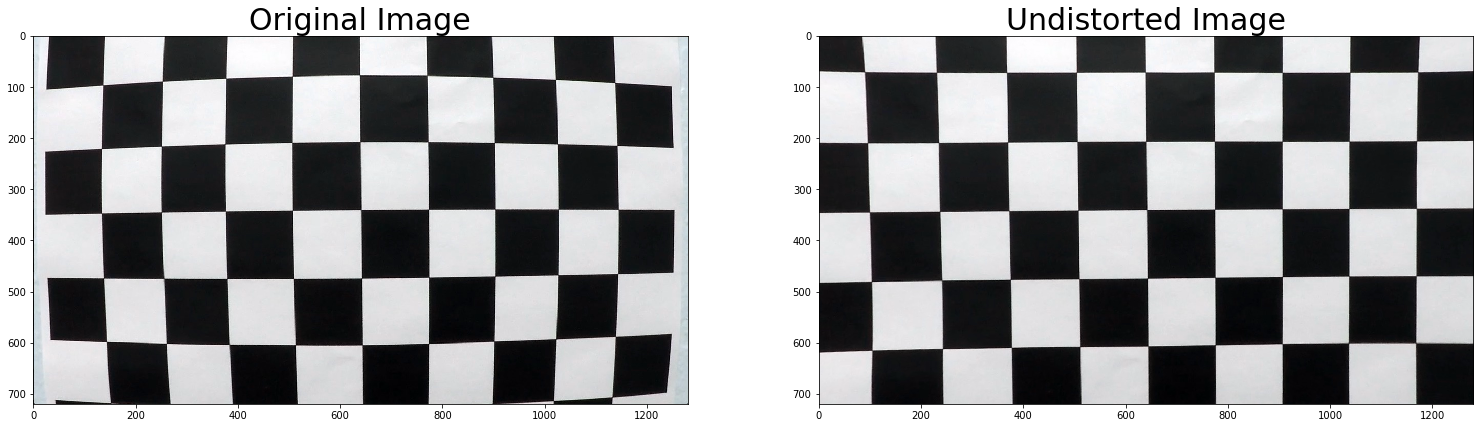

In [4]:
undist = cal_undistort(img)
    
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

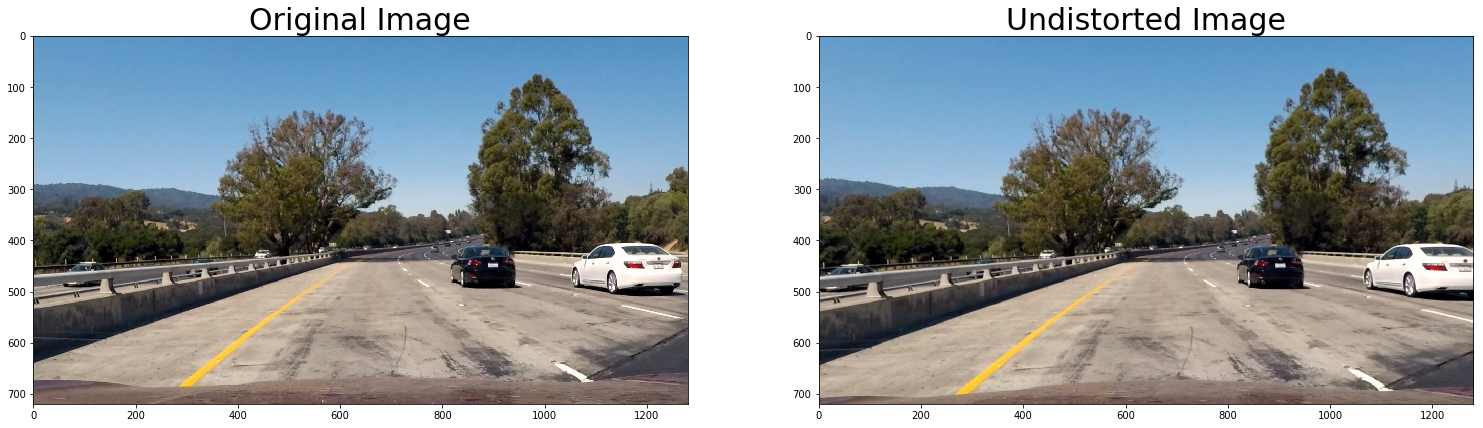

In [5]:
img = mpimg.imread('./test_images/test1.jpg')
undist = cal_undistort(img)
    
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Third step——... to create a thresholded binary image.

In [6]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary

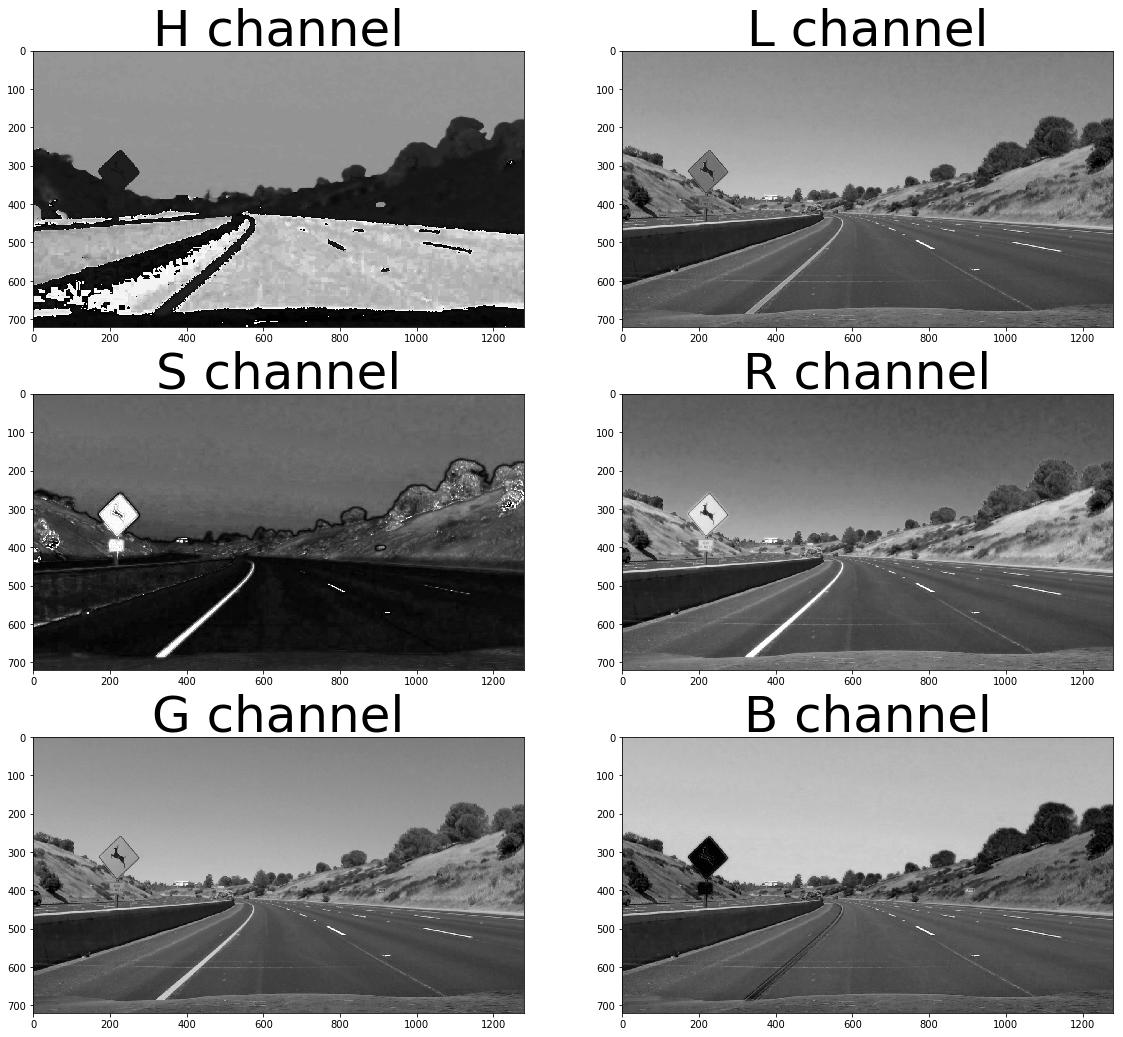

In [7]:
test_imgs = ['./test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg',
             './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']

i = random.randint(0,len(test_imgs)-1)
fname = test_imgs[i]
img = mpimg.imread(fname) 

# Plot different channels
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]

f, (ax) = plt.subplots(3, 2, figsize=(15, 15))
ax[0, 0].imshow(h_channel, cmap='gray')
ax[0, 0].set_title('H channel', fontsize=50)
ax[0, 1].imshow(l_channel, cmap='gray')
ax[0, 1].set_title('L channel', fontsize=50)
ax[1, 0].imshow(s_channel, cmap='gray')
ax[1, 0].set_title('S channel', fontsize=50)
ax[1, 1].imshow(r_channel, cmap='gray')
ax[1, 1].set_title('R channel', fontsize=50)
ax[2, 0].imshow(g_channel, cmap='gray')
ax[2, 0].set_title('G channel', fontsize=50)
ax[2, 1].imshow(b_channel, cmap='gray')
ax[2, 1].set_title('B channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    From the pictures shown above, the S channel is the best one to show the lines and curves of the picture.

Text(0.5,1,'Y sobel on HLS')

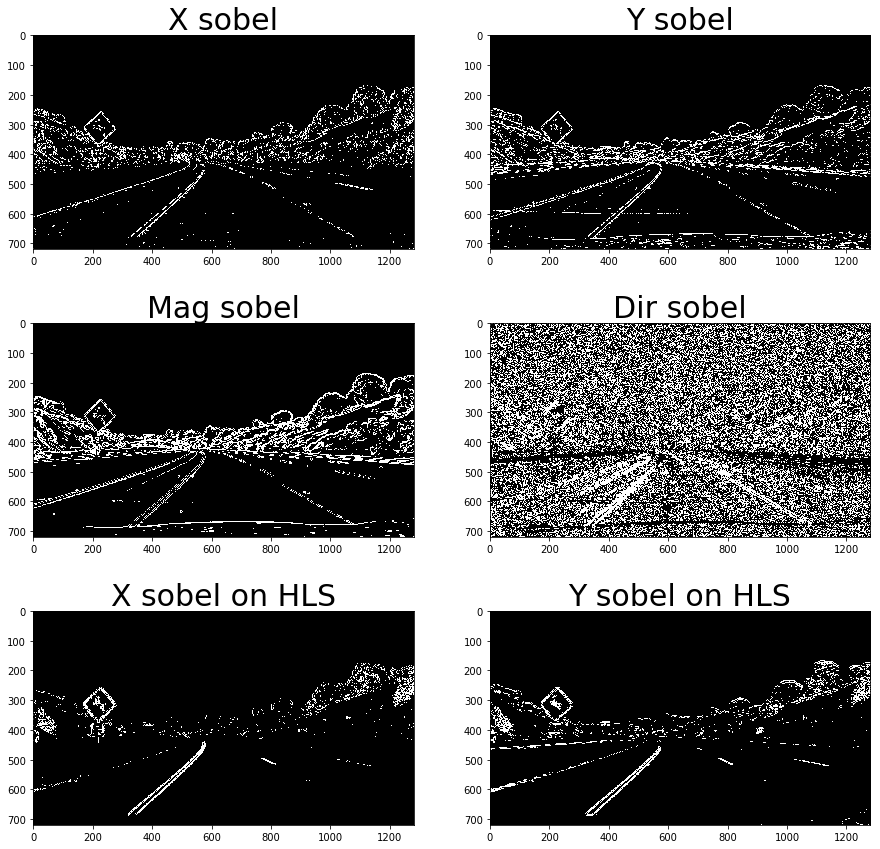

In [8]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def abs_sobel_thresh_hls(img, orient='x', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    if orient == 'x':
        sobel = cv2.Sobel(hls, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(hls, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_mag = np.uint8( 255 * mag / np.max(mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(dir, dtype=np.uint8)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output
    
# Run the function
x_sobel = abs_sobel_thresh(img, 'x', (20, 100))
y_sobel = abs_sobel_thresh(img, 'y', (20, 100))
mag_sobel = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
dir_sobel = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
x_sobel_hls = abs_sobel_thresh_hls(img, 'x', (20, 255))
y_sobel_hls = abs_sobel_thresh_hls(img, 'y', (20, 255))

# Plot the result
f, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0, 0].imshow(x_sobel, cmap='gray')
ax[0, 0].set_title('X sobel', fontsize=30)
ax[0, 1].imshow(y_sobel, cmap='gray')
ax[0, 1].set_title('Y sobel', fontsize=30)
ax[1, 0].imshow(mag_sobel, cmap='gray')
ax[1, 0].set_title('Mag sobel', fontsize=30)
ax[1, 1].imshow(dir_sobel, cmap='gray')
ax[1, 1].set_title('Dir sobel', fontsize=30)
ax[2, 0].imshow(x_sobel_hls, cmap='gray')
ax[2, 0].set_title('X sobel on HLS', fontsize=30)
ax[2, 1].imshow(y_sobel_hls, cmap='gray')
ax[2, 1].set_title('Y sobel on HLS', fontsize=30)

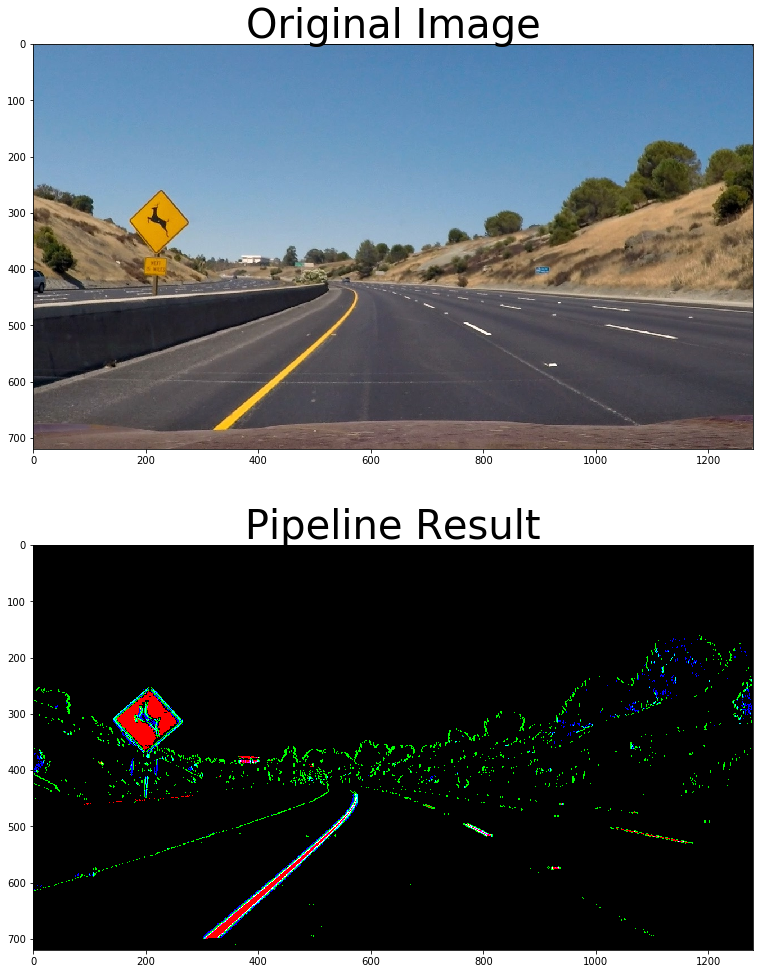

In [9]:
# Edit this function to create your own pipeline.
def rgb_select(img, thresh=(0, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def make_binary(img):
    # Threshold color channel
    r_binary = rgb_select(img, (220, 255))
    
    # Threshold based on sobel edge detection  
    sobel = abs_sobel_thresh(img, 'x', (40, 255))
    
    # Complex threshold
    c_binary = abs_sobel_thresh_hls(img, 'x', (50, 255))
    
    # Stack each channel
    color_binary = np.dstack((r_binary, sobel, c_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel)
    combined_binary[(c_binary == 1) | (sobel == 1) | (r_binary == 1)] = 1
    
    return (combined_binary, color_binary)

undist = cal_undistort(img)
(comb_bin, col_bin) = make_binary(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(col_bin)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# base = os.path.splitext(os.path.basename(fname))[0]
# mpimg.imsave('./Test_' + base + '.png', res)

# Fourth Step—Apply a perspective transform to rectify binary image

In [10]:
def perspective_transform(img, M):  
    warped = cv2.warpPerspective(img,M,(img_size),flags=cv2.INTER_LINEAR)
    return warped

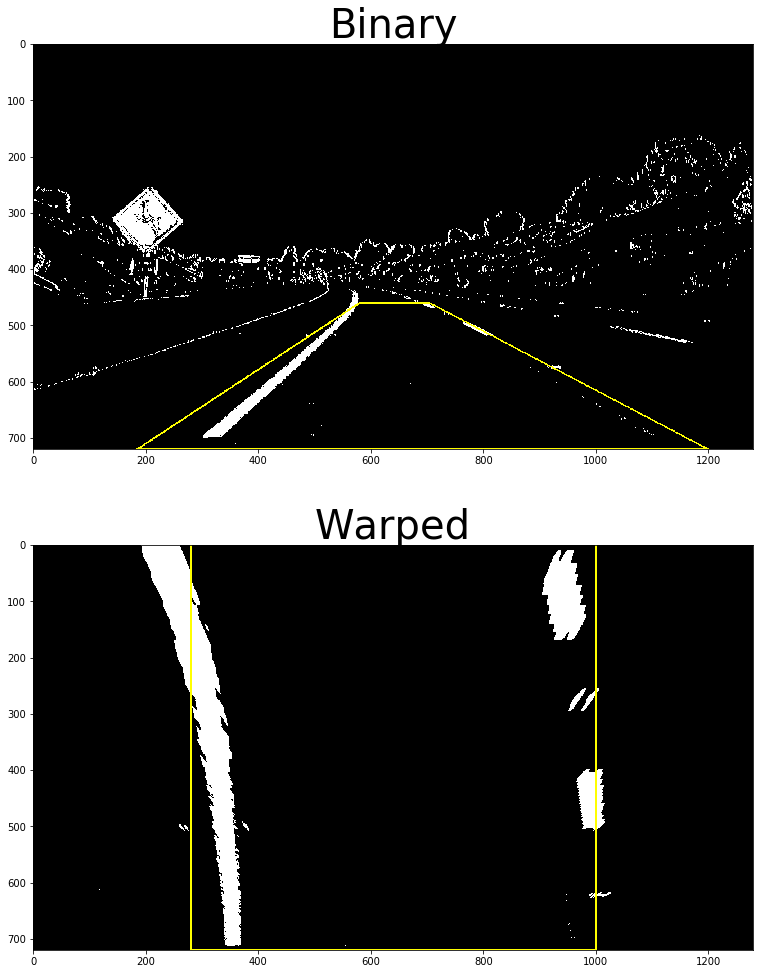

In [11]:
src = np.float32([[185, img_size[1]],[580, 460], [705, 460], [1200, img_size[1]]])
dst = np.float32([[280, img_size[1]], [280, 0], [1000, 0], [1000, img_size[1]]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
warped = perspective_transform(comb_bin,M)

# Plot the result
colored_comb_bin = np.dstack((comb_bin, comb_bin, comb_bin)) * 255
cv2.polylines(colored_comb_bin, [np.array(src,dtype=np.int32).reshape((-1, 1, 2))], True, (255,255,0), thickness = 2)

colored_warped = np.dstack((warped, warped, warped)) * 255
cv2.polylines(colored_warped, [np.array(dst, dtype=np.int32).reshape((-1, 1, 2))], True, (255,255,0), thickness=2)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
f.tight_layout()

ax1.imshow(colored_comb_bin)
ax1.set_title('Binary', fontsize=40)
res = col_bin
ax2.imshow(colored_warped)
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Detect lane pixels and fit to find the lane boundary.

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
 
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - ( window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        ##Find the four below boundaries of the window
        win_xleft_low = leftx_current  - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img,(win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds

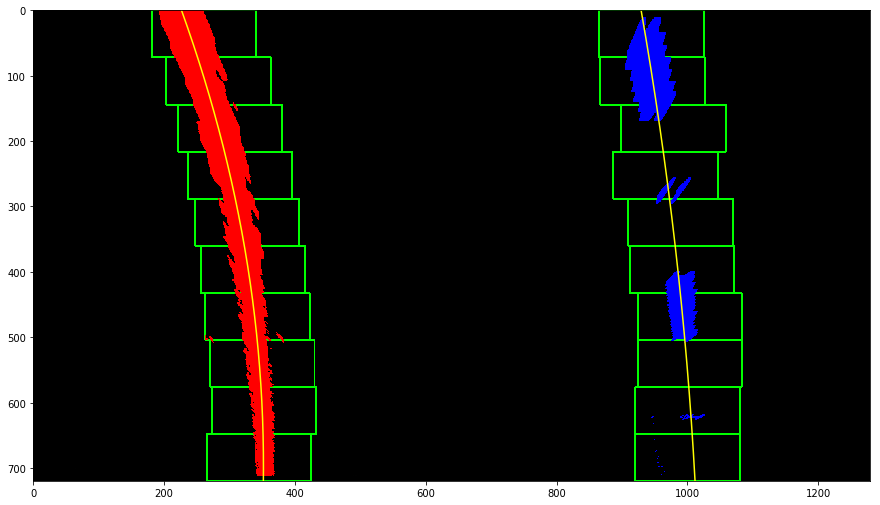

In [13]:
def fit_polynomial(binary_warped, vis, chose=1):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    if vis:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.figure(figsize=(15, 15))
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)

    if chose == 1:
        return (ploty, left_fit, right_fit, left_fitx, right_fitx)
    else:
        return left_fit, right_fit, left_lane_inds, right_lane_inds

(ploty, left_fit, right_fit, left_fitx, right_fitx) = fit_polynomial(warped, True)

In [14]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
 
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

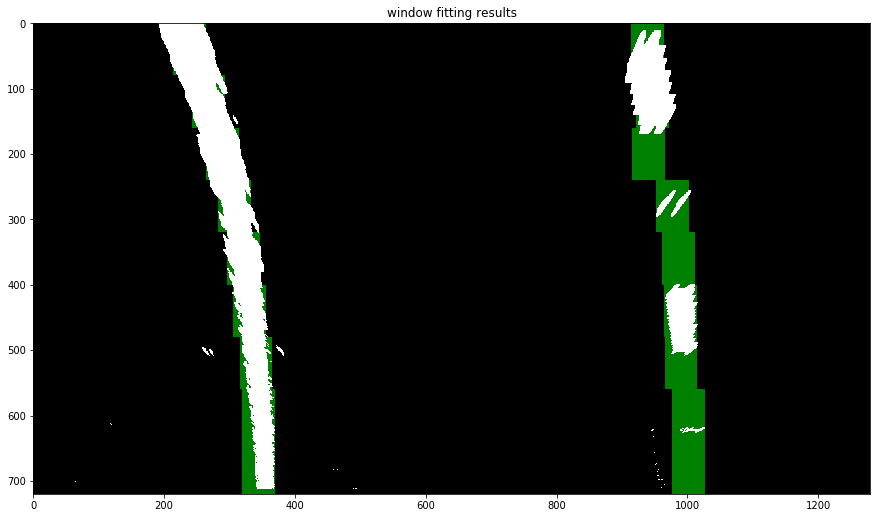

In [15]:
# window settings
# Break image into 9 vertical layers since image height is 720
window_width = 50 
window_height = 80 
margin = 100 # How much to slide left and right for searching
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

else:
    #if no window centers found, just display orginal road image
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure(figsize=(15, 15))
plt.imshow(output)
plt.title('window fitting results')
plt.show()

# Determine the curvature of the lane and vehicle position with respect to center.

In [16]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    #Calculates the curvature of polynomial functions in pixels.    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
#     print ("y_eval:",y_eval)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
#     print (left_fit_cr)
#     print (right_fit_cr)
    # Do the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    pos = (img_size[0] / 2 - (left_fitx[-1] + right_fitx[-1]) / 2) * xm_per_pix
#     print ((left_fitx[-1] + right_fitx[-1]) / 2)
#     print ((left_curverad-right_curverad)/2)

    return left_curverad, right_curverad, pos

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, pos = measure_curvature_real(ploty, left_fitx, right_fitx)
# print(left_curverad, 'm', right_curverad, 'm', pos, 'm')

# Warp the detected lane boundaries back onto the original image and output visual display.

In [17]:
def draw_lane(undist, warped, left_fitx, right_fitx, ploty, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1, (200,255,155), 2, cv2.LINE_AA)
    return new_img

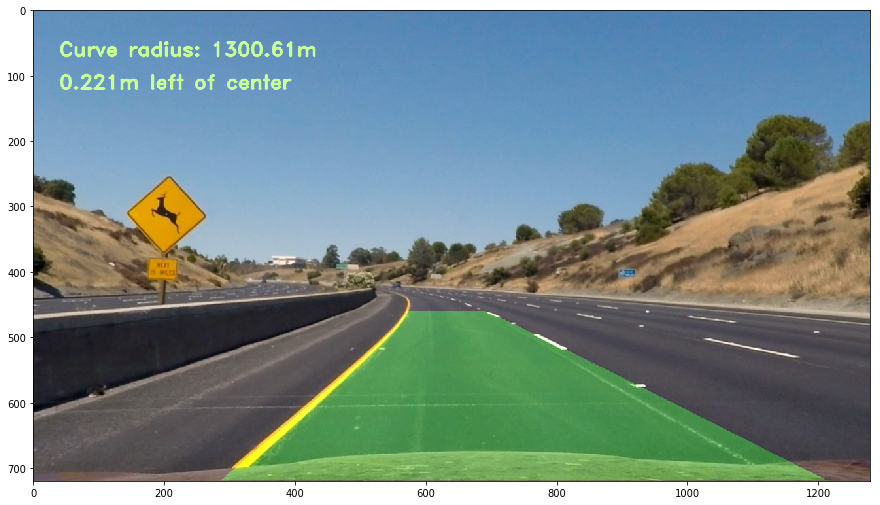

In [18]:
M_inv = cv2.getPerspectiveTransform(dst, src)
result = draw_lane(undist, warped, left_fitx, right_fitx, ploty, M_inv)
result = draw_data(result, (left_curverad + right_curverad)/2, pos)

plt.figure(figsize=(15, 15))
plt.imshow(result)

In [22]:
def process_img(img, base = "", output_dir = ""):
    # Undistort
    undist = cal_undistort(img)
#     cv2.imwrite(output_dir + '/undist_' + base + '.jpg', undist)
    
    # Make binary
    bin_img, dbg_col_bin = make_binary(undist)
#     cv2.imwrite(output_dir + '/bin_' + base + '.jpg', bin_img.astype('uint8') * 255)
    
    # Perspective transform
    warped_bin_img = perspective_transform(bin_img,M)
#     cv2.imwrite(output_dir + '/warped_' + base + '.jpg', warped_bin_img.astype('uint8') * 255)
    
#     # Find lanes and fit polynomial
    ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_bin_img, False)
    
#     # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad, pos = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    result = draw_lane(undist, warped, left_fitx, right_fitx, ploty, M_inv)
    result = draw_data(result, (left_curverad + right_curverad)/2, pos)
    
    return result

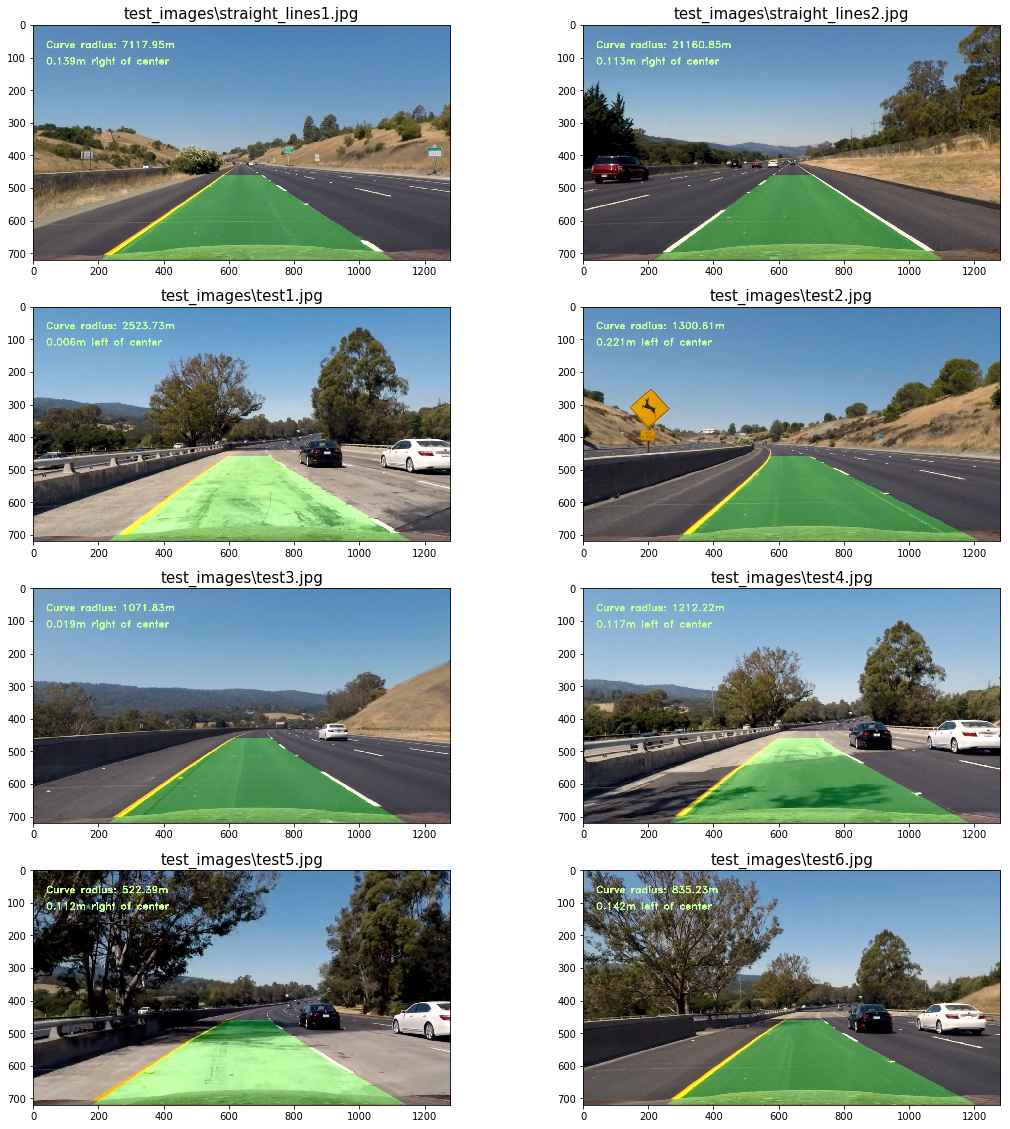

In [23]:
# Make a list of images
images = glob.glob('test_images/*.jpg') + glob.glob('dbg/*.jpg')
images_count = len(images)
fig, ax = plt.subplots(int((images_count + 1) / 2), 2, figsize=(10, 25))

# Step through the list
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get base name
    base = os.path.basename(fname)
    base = os.path.splitext(base)[0]
    
    result = process_img(img, base, 'output_images')
    
    # plot original and final image
    row = int(idx / 2)
    col = idx % 2
    ax[row, col].set_title(fname, fontsize=15)
    ax[row, col].imshow(result)
    
plt.subplots_adjust(left=0.1, right=1.5, top=0.6, bottom=0.)

In [24]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip = VideoFileClip('test_videos/project_video.mp4')
out_clip = clip.fl_image(process_img)
%time out_clip.write_videofile('test_videos_output/project_video.mp4', audio=False)

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 2min 7s


In [ ]:
clip = VideoFileClip('test_videos/challenge_video.mp4')
challenge_clip = clip.fl_image(process_img) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile('test_videos_output/challenge_video.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:33<00:00,  5.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 1min 34s


In [ ]:
clip = VideoFileClip('test_videos/harder_challenge_video.mp4')
challenge_clip = clip.fl_image(process_img) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile('test_videos_output/harder_challenge_video.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [03:53<00:29,  4.57it/s]

# Discussion
    As I wrote in the writeup, I did some try and finally get a better pipeline.

In [21]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

l_line = Line()
r_line = Line()

In [22]:
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

def drawlane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [23]:
def pipeline(img):
    # Undistort
    img_undistort = cal_undistort(img)
    
    # Perspective Transform
    img_unwarp = perspective_transform(img_undistort, M)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined

def process_image(img):
    new_img = np.copy(img)
    img_bin = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds =  fit_polynomial(img_bin, False, chose=0)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
         
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)

        if abs(650 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = drawlane(new_img, img_bin, l_line.best_fit, r_line.best_fit, M_inv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out

In [24]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip = VideoFileClip('test_videos/project_video.mp4')
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile('test_videos_output/project_video_f.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_f.mp4
[MoviePy] Writing video test_videos_output/project_video_f.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:48<00:00,  4.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_f.mp4 

Wall time: 4min 50s


In [25]:
clip = VideoFileClip('test_videos/challenge_video.mp4')
challenge_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile('test_videos_output/challenge_video_f.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_f.mp4
[MoviePy] Writing video test_videos_output/challenge_video_f.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:16<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_f.mp4 

Wall time: 2min 18s


In [26]:
clip = VideoFileClip('test_videos/harder_challenge_video.mp4')
challenge_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile('test_videos_output/harder_challenge_video_f.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video_f.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video_f.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [06:58<00:00,  2.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video_f.mp4 

Wall time: 7min 1s
